In [2]:
import pandas as pd
from sklearn.model_selection import train_test_split
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification, AdamW
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Load the dataset
data_path = '/user/HS400/dd00830/Downloads/Dissertation/Dataset.csv'
df = pd.read_csv(data_path)

# Drop rows with missing values in 'selftext' and 'Label' columns
df = df.dropna(subset=['selftext', 'Label'])

# Text preprocessing function
def preprocess_text(text):
    text = text.lower()  # Lowercasing
    text = text.replace('\n', ' ')  # Replace newlines with spaces
    text = ''.join([c for c in text if c.isalnum() or c.isspace()])  # Remove special characters
    return text

# Apply text preprocessing to 'selftext'
df['selftext'] = df['selftext'].apply(preprocess_text)

# Preprocess the labels to be lowercase
df['Label'] = df['Label'].str.lower()
# Standardize labels by stripping leading/trailing whitespaces
df['Label'] = df['Label'].str.strip()

# Merge both versions of 'trauma and stress'
df['Label'] = df['Label'].replace('trauma and stress ', 'trauma and stress')

# Split the dataset into train and test sets
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

train_texts = train_df['selftext'].tolist()
test_texts = test_df['selftext'].tolist()
train_labels = train_df['Label'].tolist()
test_labels = test_df['Label'].tolist()

# Clean the texts to ensure they are strings
def clean_texts(texts):
    clean_texts = []
    for text in texts:
        if isinstance(text, str):
            clean_texts.append(text)
        else:
            clean_texts.append(str(text))  # Convert non-string entries to string or handle as needed
    return clean_texts

train_texts_clean = clean_texts(train_texts)
test_texts_clean = clean_texts(test_texts)

# Combine all labels from both training and testing sets
all_labels = train_labels + test_labels

# Create a label map that covers all unique labels
unique_labels = list(set(all_labels))
label_map = {label: idx for idx, label in enumerate(unique_labels)}

# Convert the labels using the updated label_map
train_labels = [label_map[label] for label in train_labels]
test_labels = [label_map[label] for label in test_labels]

# Load the tokenizer
tokenizer = AutoTokenizer.from_pretrained("emilyalsentzer/Bio_ClinicalBERT")

# Tokenize the cleaned input texts and labels for training and testing sets
def tokenize_data(texts, labels, max_len=128):
    inputs = tokenizer(
        texts,
        max_length=max_len,
        padding=True,
        truncation=True,
        return_tensors="pt"
    )
    
    # Convert labels (which should now be integers) to torch tensors
    labels = torch.tensor(labels, dtype=torch.long)
    
    return inputs, labels

train_inputs, train_labels = tokenize_data(train_texts_clean, train_labels)
test_inputs, test_labels = tokenize_data(test_texts_clean, test_labels)

print("Full dataset tokenization and labeling completed successfully.")


/user/HS400/dd00830/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


Full dataset tokenization and labeling completed successfully.


In [2]:
unique_labels

['drug and alcohol', 'trauma and stress', 'personality', 'early life']

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/10
Average training loss for epoch 1: 1.379
Training accuracy for epoch 1: 0.308
Validation loss for epoch 1: 1.295
Validation accuracy for epoch 1: 0.375
Epoch 2/10
Average training loss for epoch 2: 1.052
Training accuracy for epoch 2: 0.523
Validation loss for epoch 2: 0.981
Validation accuracy for epoch 2: 0.562
Epoch 3/10
Average training loss for epoch 3: 0.678
Training accuracy for epoch 3: 0.736
Validation loss for epoch 3: 0.858
Validation accuracy for epoch 3: 0.662
Epoch 4/10
Average training loss for epoch 4: 0.418
Training accuracy for epoch 4: 0.861
Validation loss for epoch 4: 0.940
Validation accuracy for epoch 4: 0.650
Epoch 5/10
Average training loss for epoch 5: 0.220
Training accuracy for epoch 5: 0.934
Validation loss for epoch 5: 1.029
Validation accuracy for epoch 5: 0.662
Epoch 6/10
Average training loss for epoch 6: 0.117
Training accuracy for epoch 6: 0.973
Validation loss for epoch 6: 1.066
Validation accuracy for epoch 6: 0.700
Epoch 7/10
Average tra

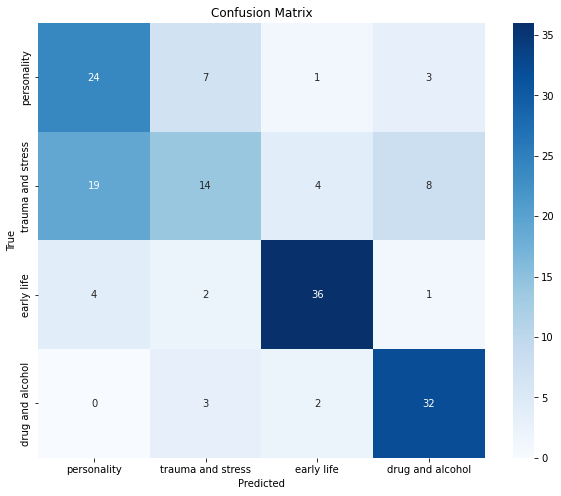

In [6]:
# Load the ClinicalBERT model for sequence classification
model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=len(label_map))

# Move the model to GPU if available
#device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
device='cuda'
model.to("cpu")

# Create DataLoader for the training set and the test set
def create_data_loader(inputs, labels, batch_size=16):
    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Set batch size
batch_size = 8

train_dataloader = create_data_loader(train_inputs, train_labels, batch_size)
test_dataloader = create_data_loader(test_inputs, test_labels, batch_size)

# Set optimizer and learning rate
optimizer = AdamW(model.parameters(), lr=2e-5)

# Function to calculate accuracy during training and evaluation
def calculate_accuracy(predictions, true_labels):
    preds = torch.argmax(predictions, dim=1).cpu().numpy()
    true_labels = true_labels.cpu().numpy()
    return accuracy_score(true_labels, preds)

def train_model_with_validation_and_tracking(model, train_dataloader, test_dataloader, optimizer, device, epochs=10):
    model.train()
    
    training_loss = []
    validation_loss = []
    training_accuracies = []
    validation_accuracies = []

    for epoch in range(epochs):
        print(f"Epoch {epoch + 1}/{epochs}")
        
        total_train_loss = 0
        total_train_correct = 0
        total_train_samples = 0

        model.train()  # Ensure the model is in training mode

        # Training loop
        for batch in train_dataloader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            
            model.zero_grad()  # Clear any accumulated gradients
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
            
            loss = outputs.loss
            total_train_loss += loss.item()
            
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            total_train_correct += (preds == labels).sum().item()
            total_train_samples += labels.size(0)
            
            loss.backward()
            optimizer.step()
        
        # Calculate average training loss and accuracy for the epoch
        avg_train_loss = total_train_loss / len(train_dataloader)
        training_loss.append(avg_train_loss)  # Store the training loss

        train_accuracy = total_train_correct / total_train_samples
        training_accuracies.append(train_accuracy)  # Store the training accuracy

        print(f"Average training loss for epoch {epoch + 1}: {avg_train_loss:.3f}")
        print(f"Training accuracy for epoch {epoch + 1}: {train_accuracy:.3f}")

        # Validation loop (evaluate on test data)
        model.eval()  # Put the model in evaluation mode
        
        total_val_loss = 0
        total_val_correct = 0
        total_val_samples = 0

        with torch.no_grad():
            for batch in test_dataloader:
                input_ids, attention_mask, labels = [x.to(device) for x in batch]
                outputs = model(input_ids=input_ids, attention_mask=attention_mask, labels=labels)
                loss = outputs.loss
                total_val_loss += loss.item()
                
                logits = outputs.logits
                preds = torch.argmax(logits, dim=1)
                
                total_val_correct += (preds == labels).sum().item()
                total_val_samples += labels.size(0)
        
        # Calculate validation loss and accuracy
        avg_val_loss = total_val_loss / len(test_dataloader)
        validation_loss.append(avg_val_loss)

        val_accuracy = total_val_correct / total_val_samples
        validation_accuracies.append(val_accuracy)

        print(f"Validation loss for epoch {epoch + 1}: {avg_val_loss:.3f}")
        print(f"Validation accuracy for epoch {epoch + 1}: {val_accuracy:.3f}")
    
    return training_loss, validation_loss, training_accuracies, validation_accuracies

# Run the modified training loop with validation and tracking
training_loss, validation_loss, training_accuracies, validation_accuracies = train_model_with_validation_and_tracking(
    model, train_dataloader, test_dataloader, optimizer, device, epochs=10
)

# Plot training loss and validation accuracy
def plot_loss_and_accuracy(training_loss, validation_accuracies, epochs):
    plt.figure(figsize=(10, 5))

# Evaluate the model
def evaluate_model(model, dataloader, device):
    model.eval()
    
    predictions, true_labels = [], []
    
    with torch.no_grad():
        for batch in dataloader:
            input_ids, attention_mask, labels = [x.to(device) for x in batch]
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            
            preds = torch.argmax(logits, dim=1).cpu().numpy()
            label_ids = labels.cpu().numpy()
            
            predictions.extend(preds)
            true_labels.extend(label_ids)
    
    return predictions, true_labels

# Get predictions and true labels for the test set
test_predictions, test_true_labels = evaluate_model(model, test_dataloader, device)

# Compute the accuracy
accuracy = accuracy_score(test_true_labels, test_predictions)
print(f"Test Accuracy: {accuracy:.3f}")

# Generate classification report
class_report = classification_report(test_true_labels, test_predictions, target_names=unique_labels)
print("Classification Report:\n", class_report)

# Confusion Matrix
conf_matrix = confusion_matrix(test_true_labels, test_predictions)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=unique_labels, yticklabels=unique_labels)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()


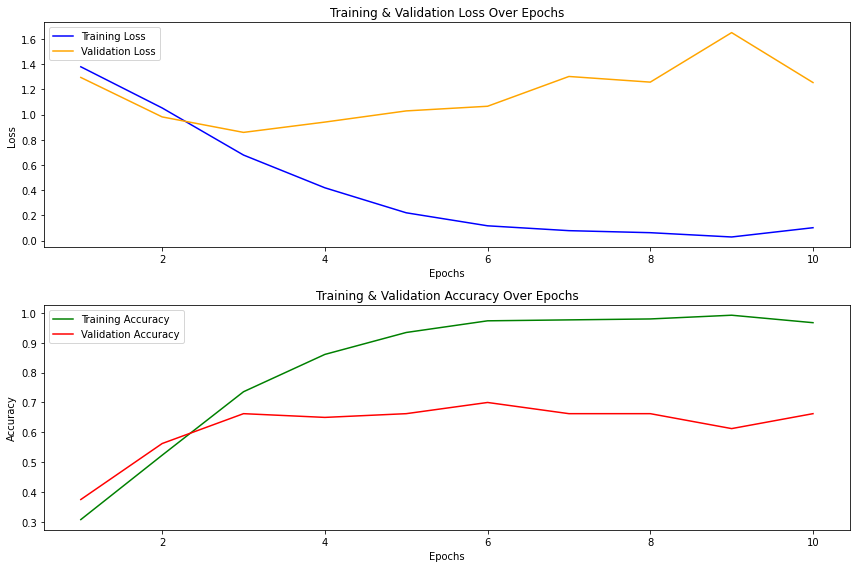

In [7]:
# Plot training loss, validation loss, training accuracy, and validation accuracy
def plot_loss_and_accuracy(training_loss, validation_loss, training_accuracies, validation_accuracies, epochs):
    plt.figure(figsize=(12, 8))

    # Plot training and validation loss
    plt.subplot(2, 1, 1)
    plt.plot(range(1, epochs + 1), training_loss, label='Training Loss', color='blue')
    plt.plot(range(1, epochs + 1), validation_loss, label='Validation Loss', color='orange')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.title('Training & Validation Loss Over Epochs')
    plt.legend()

    # Plot training and validation accuracy
    plt.subplot(2, 1, 2)
    plt.plot(range(1, epochs + 1), training_accuracies, label='Training Accuracy', color='green')
    plt.plot(range(1, epochs + 1), validation_accuracies, label='Validation Accuracy', color='red')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.title('Training & Validation Accuracy Over Epochs')
    plt.legend()

    plt.tight_layout()
    plt.show()

# Plot the results
plot_loss_and_accuracy(training_loss, validation_loss, training_accuracies, validation_accuracies, epochs=10)

## HYPER PARAMETER TUNING:-

In [7]:
import random
import numpy as np
from sklearn.model_selection import ParameterSampler
from transformers import get_linear_schedule_with_warmup, AdamW

# Define the possible hyperparameter values to search over
hyperparameter_grid = {
    'learning_rate': [5e-5, 3e-5, 2e-5, 1e-5],
    'batch_size': [16, 32,64],
    'epochs': [2, 3, 4,6,8,10,12]
}
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# Function to create data loader
def create_data_loader(inputs, labels, batch_size):
    dataset = TensorDataset(inputs['input_ids'], inputs['attention_mask'], labels)
    return DataLoader(dataset, batch_size=batch_size, shuffle=True)

# Function to perform training with given hyperparameters
def train_with_hyperparams(learning_rate, batch_size, epochs):
    # Set up the model, optimizer and dataloaders based on the parameters
    model = AutoModelForSequenceClassification.from_pretrained("emilyalsentzer/Bio_ClinicalBERT", num_labels=len(label_map))
    model.to(device)
    
    optimizer = AdamW(model.parameters(), lr=learning_rate)
    
    # Create DataLoader for the training set and the test set
    train_dataloader = create_data_loader(train_inputs, train_labels, batch_size)
    test_dataloader = create_data_loader(test_inputs, test_labels, batch_size)
    
    # Scheduler for learning rate decay
    total_steps = len(train_dataloader) * epochs
    scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

    # Train the model
    train_loss, val_loss, train_acc, val_acc = train_model_with_validation_and_tracking(
        model, train_dataloader, test_dataloader, optimizer, device, epochs
    )
    
    # Return validation accuracy for hyperparameter tuning
    return np.mean(val_acc), train_loss, val_loss, train_acc, val_acc

# Perform random search over the hyperparameters
def random_search_hyperparameter_tuning(hyperparameter_grid, n_iter=5):
    param_sampler = ParameterSampler(hyperparameter_grid, n_iter=n_iter, random_state=42)
    
    best_accuracy = 0
    best_params = None
    results = []

    for i, params in enumerate(param_sampler):
        print(f"Running configuration {i+1}/{n_iter} with params: {params}")
        
        # Train with the given hyperparameters
        val_accuracy, train_loss, val_loss, train_acc, val_acc = train_with_hyperparams(
            learning_rate=params['learning_rate'],
            batch_size=params['batch_size'],
            epochs=params['epochs']
        )
        
        # Save the result
        results.append({
            'params': params,
            'val_accuracy': val_accuracy,
            'train_loss': train_loss,
            'val_loss': val_loss,
            'train_acc': train_acc,
            'val_acc': val_acc
        })
        
        # Keep track of the best performing configuration
        if val_accuracy > best_accuracy:
            best_accuracy = val_accuracy
            best_params = params
    
    print(f"Best Hyperparameters: {best_params}, Validation Accuracy: {best_accuracy}")
    
    return best_params, results

# Run random search
best_hyperparameters, all_results = random_search_hyperparameter_tuning(hyperparameter_grid, n_iter=10)

# Display all the results
for result in all_results:
    print(f"Params: {result['params']}, Validation Accuracy: {result['val_accuracy']}")


Running configuration 1/10 with params: {'learning_rate': 3e-05, 'epochs': 8, 'batch_size': 64}


/user/HS400/dd00830/.local/lib/python3.10/site-packages/huggingface_hub/file_download.py:1150: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at emilyalsentzer/Bio_ClinicalBERT and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


Epoch 1/8


RuntimeError: CUDA out of memory. Tried to allocate 24.00 MiB (GPU 0; 7.92 GiB total capacity; 7.04 GiB already allocated; 7.94 MiB free; 7.19 GiB reserved in total by PyTorch) If reserved memory is >> allocated memory try setting max_split_size_mb to avoid fragmentation.  See documentation for Memory Management and PYTORCH_CUDA_ALLOC_CONF